In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
OUTPUT_DIR = './preprocessed'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Filter design
def design_filters(fs=250.0):
    # Bandpass 1-40 Hz
    bp_b, bp_a = butter(4, [1/(fs/2), 40/(fs/2)], btype='band')
    # Notch at 50 Hz
    notch_b, notch_a = iirnotch(50/(fs/2), Q=30)
    return bp_b, bp_a, notch_b, notch_a

# Preprocessing steps for one trial
def preprocess_trial(df):
    eeg_cols = ['FZ','C3','CZ','C4','PZ','PO7','OZ','PO8']
    motion_cols = ['AccX','AccY','AccZ','Gyro1','Gyro2','Gyro3']
    val_col = 'Validation'

    # 1) Motion artifact detection
    motion_mag = np.sqrt((df[motion_cols]**2).sum(axis=1))
    mot_thresh = np.percentile(motion_mag, 95)
    bad_mask = motion_mag > mot_thresh

    # 2) Mask EEG
    data = df[eeg_cols].copy().values
    data[bad_mask, :] = np.nan
    data[df[val_col] == 0, :] = np.nan

    # 3) Interpolation
    for ch in range(data.shape[1]):
        col = data[:, ch]
        nans = np.isnan(col)
        if nans.all():
            continue
        idx = np.arange(len(col))
        data[nans, ch] = np.interp(idx[nans], idx[~nans], col[~nans])

    # 4) Filtering
    bp_b, bp_a, notch_b, notch_a = design_filters()
    for ch in range(data.shape[1]):
        data[:, ch] = filtfilt(bp_b, bp_a, data[:, ch])
        data[:, ch] = filtfilt(notch_b, notch_a, data[:, ch])

    # 5) Baseline correction (first 0.5s)
    bs = int(0.5 * 250)
    baseline = data[:bs].mean(axis=0)
    data -= baseline
    return data

# Load index DataFrame
def load_index(fname, label_col=True):
    df = pd.read_csv(os.path.join(BASE_PATH, fname))
    cols = ['id','subject_id','task','trial_session','trial'] + (['label'] if label_col else [])
    return df[cols]

# Process a split, grouping by task
def process_split(df, has_label=True):
    data_dict = {'MI': {'X': [], 'y': []}, 'SSVEP': {'X': [], 'y': []}}
    for _, row in df.iterrows():
        # Identify folder
        idx = row['id']
        split = 'train' if idx <= 4800 else 'validation' if idx <= 4900 else 'test'
        # Load EEGdata
        path = os.path.join(BASE_PATH, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        df_eeg = pd.read_csv(path)
        # Extract correct segment
        n_samp = 2250 if row['task']=='MI' else 1750
        start = (row['trial']-1)*n_samp
        seg = df_eeg.iloc[int(start):int(start+n_samp)].reset_index(drop=True)
        proc = preprocess_trial(seg)
        data_dict[row['task']]['X'].append(proc.T)
        if has_label:
            data_dict[row['task']]['y'].append(row['label'])
    # Stack
    for t in data_dict:
        X = np.stack(data_dict[t]['X'])
        y = np.array(data_dict[t]['y']) if has_label else None
        data_dict[t]['X'] = X
        data_dict[t]['y'] = y
    return data_dict

# Execute processing and save
for fname, label_col in [('train.csv', True), ('validation.csv', True), ('test.csv', False)]:
    df_idx = load_index(fname, label_col)
    results = process_split(df_idx, label_col)
    for task, d in results.items():
        out_file = f"{os.path.splitext(fname)[0]}_{task}.npz"
        path = os.path.join(OUTPUT_DIR, out_file)
        if label_col:
            np.savez_compressed(path, X=d['X'], y=d['y'])
        else:
            np.savez_compressed(path, X=d['X'])
        print(f"Saved {out_file}: X={d['X'].shape}" + (f", y={d['y'].shape}" if d['y'] is not None else ''))
print('Preprocessing complete.')


KeyboardInterrupt: 

2025-06-26 07:16:19.415914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750922179.589465      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750922179.640203      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750922193.650741      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750922193.651313      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2250, 32)            │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1125, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1125, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1125, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 562, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 562, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 562, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,986 (242.13 KB)

 Trainable params: 61,538 (240.38 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


I0000 00:00:1750922198.723475     102 service.cc:148] XLA service 0x7db3ec056d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750922198.724152     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750922198.724172     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750922199.153826     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/37 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4990 - loss: 0.8233

I0000 00:00:1750922202.539321     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.4985 - loss: 0.8108 - val_accuracy: 0.5200 - val_loss: 0.8597
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5299 - loss: 0.7415 - val_accuracy: 0.5800 - val_loss: 0.8089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4841 - loss: 0.7319 - val_accuracy: 0.5800 - val_loss: 0.6922
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4833 - loss: 0.7169 - val_accuracy: 0.4800 - val_loss: 0.7108
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5119 - loss: 0.7050 - val_accuracy: 0.5200 - val_loss: 0.7849
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5072 - loss: 0.7002 - val_accuracy: 0.4200 - val_loss: 0.7442
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5201 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.7481
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5063 - loss: 0.7025 - val_accuracy: 0.5400 - val_loss: 0

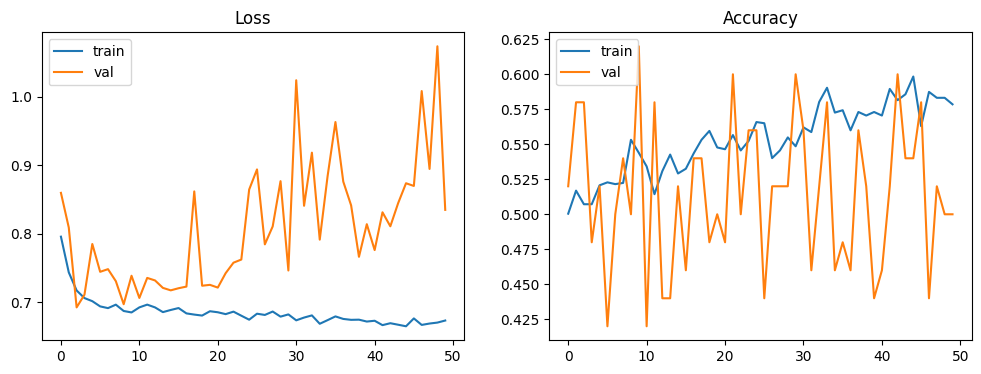

In [2]:
# ▶️ Kaggle‑runnable cell: MI CNN training
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1) Load preprocessed MI data
train = np.load('/kaggle/working/preprocessed/train_MI.npz')
X_train, y_train = train['X'], train['y']
val   = np.load('/kaggle/working/preprocessed/validation_MI.npz')
X_val,   y_val   = val['X'],   val['y']

# ensure float32 and channel‑first → channel‑last for Keras
X_train = X_train.astype('float32').transpose(0,2,1)
X_val   = X_val.astype('float32').transpose(0,2,1)

# one‑hot labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train == 'Right', num_classes=2)
y_val   = keras.utils.to_categorical(y_val   == 'Right', num_classes=2)

# 2) Data augmentation generator
def aug_generator(X, y, batch_size=32):
    n_samples = X.shape[0]
    while True:
        idx = np.random.randint(0, n_samples, batch_size)
        batch_x = X[idx].copy()
        batch_y = y[idx]
        # add small Gaussian noise
        noise = np.random.normal(0, 0.01, batch_x.shape)
        batch_x += noise
        # random time shift up to ±50 samples
        shifts = np.random.randint(-50, 51, batch_size)
        for i, s in enumerate(shifts):
            batch_x[i] = np.roll(batch_x[i], s, axis=0)
        yield batch_x, batch_y

train_gen = aug_generator(X_train, y_train, batch_size=64)

# 3) Build 1D‑CNN model
input_shape = X_train.shape[1:]  # (samples, channels)
model = keras.Sequential([
    layers.Input(input_shape),
    layers.Conv1D(32, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(64, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 4) Training with callbacks
ckpt = keras.callbacks.ModelCheckpoint(
    'best_mi_cnn.h5', monitor='val_accuracy', save_best_only=True
)
hist = model.fit(
    train_gen,
    steps_per_epoch=len(X_train)//64,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[ckpt]
)

# 5) Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()
plt.show()


In [5]:
# ▶️ Kaggle‑runnable: MI CNN with CSP (time‑series) + classification report
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers

# 1) Load preprocessed MI data
train = np.load('/kaggle/working/preprocessed/train_MI.npz')
X_train, y_train = train['X'], train['y']
val   = np.load('/kaggle/working/preprocessed/validation_MI.npz')
X_val,   y_val   = val['X'],   val['y']

# X_train: (n_trials, n_channels, n_samples)
# Convert labels to binary
y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# 2) Fit CSP on raw epochs
n_components = 4  # pick 4 spatial filters
csp = CSP(n_components=n_components, reg=None, log=False, norm_trace=False)
csp.fit(X_train, y_train_bin)

# 3) Manually apply filters to get time-series components
# csp.filters_ is shape (n_components, n_channels)
filters = csp.filters_[:n_components]
def apply_csp(X):
    # X: epochs x channels x times
    return np.stack([filters.dot(epoch) for epoch in X], axis=0)

X_train_csp = apply_csp(X_train)  # (n_trials, n_components, n_samples)
X_val_csp   = apply_csp(X_val)

# 4) Prepare for Keras (timesteps, channels)
# transpose to (n_trials, n_samples, n_components)
X_train_csp = X_train_csp.astype('float32').transpose(0, 2, 1)
X_val_csp   = X_val_csp.astype('float32').transpose(0, 2, 1)

# One-hot encode labels
y_train_oh = keras.utils.to_categorical(y_train_bin, 2)
y_val_oh   = keras.utils.to_categorical(y_val_bin,   2)

# 5) Augmentation generator (light noise)
def aug_generator(X, y, batch_size=32):
    n = X.shape[0]
    while True:
        idx = np.random.randint(0, n, batch_size)
        bx = X[idx].copy()
        by = y[idx]
        bx += np.random.normal(0, 0.005, bx.shape)
        yield bx, by

train_gen = aug_generator(X_train_csp, y_train_oh, batch_size=64)

# 6) Build and compile CNN
input_shape = X_train_csp.shape[1:]
model = keras.Sequential([
    layers.Input(input_shape),
    layers.Conv1D(32, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(64, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(128,5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.6),
    layers.Dense(2, activation='softmax'),
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 7) Callbacks for F1, early stopping, and logging
class F1Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = np.argmax(self.model.predict(X_val_csp, verbose=0), axis=1)
        f1 = f1_score(y_val_bin, preds)
        logs['val_f1'] = f1
        print(f" — val_f1: {f1:.4f}")

csv_logger = keras.callbacks.CSVLogger('training_log.csv')
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('best_mi_cnn_csp.h5', monitor='val_f1', mode='max', save_best_only=True)

# 8) Train
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train_csp)//64,
    validation_data=(X_val_csp, y_val_oh),
    epochs=100,
    callbacks=[F1Callback(), csv_logger, early_stop, checkpoint]
)

# 9) Final classification report on validation
best = keras.models.load_model('best_mi_cnn_csp.h5')
val_preds = np.argmax(best.predict(X_val_csp), axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val_bin, val_preds, target_names=['Left','Right']))

Computing rank from data with rank=None
    Using tolerance 7.4e+03 (2.2e-16 eps * 8 dim * 4.2e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 2250, 32)            │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1125, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1125, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1125, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 562, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 562, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 562, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 281, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,346 (239.63 KB)

 Trainable params: 60,898 (237.88 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5272 - loss: 0.8340 — val_f1: 0.5172
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.5269 - loss: 0.8335 - val_accuracy: 0.4400 - val_loss: 0.7051 - val_f1: 0.5172
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5096 - loss: 0.7781 — val_f1: 0.5538
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.5098 - loss: 0.7782 - val_accuracy: 0.4200 - val_loss: 0.7104 - val_f1: 0.5538
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5489 - loss: 0.7502 — val_f1: 0.5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.5483 - loss: 0.7503 - val_accuracy: 0.4400 - val_loss: 0.7131 - val_f1: 0.5000
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4770 - loss: 0.7814 — val_f1: 0.4828
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.4775 - loss: 0.7812 - val_accuracy: 0.4000 - val_loss: 0.7146 - val_f1: 0.4828
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 29

In [ ]:
# ▶️ Kaggle‑runnable: MI CNN w/ CSP, extended early stopping, save both models, reports
import os
import numpy as np
from sklearn.metrics import classification_report, f1_score
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers

# 1) Load preprocessed MI data
train = np.load('/kaggle/working/preprocessed/train_MI.npz')
X_train, y_train = train['X'], train['y']
val   = np.load('/kaggle/working/preprocessed/validation_MI.npz')
X_val,   y_val   = val['X'],   val['y']

# Binary labels
y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# 2) CSP
n_comp = 4
csp = CSP(n_components=n_comp, reg=None, log=False, norm_trace=False)
csp.fit(X_train, y_train_bin)
filters = csp.filters_[:n_comp]
def apply_csp(X):
    return np.stack([filters.dot(ep) for ep in X], axis=0)

X_train_csp = apply_csp(X_train)
X_val_csp   = apply_csp(X_val)

# 3) Prepare for Keras: (trials, timesteps, components)
X_train_csp = X_train_csp.astype('float32').transpose(0,2,1)
X_val_csp   = X_val_csp.astype('float32').transpose(0,2,1)
y_train_oh = keras.utils.to_categorical(y_train_bin, 2)
y_val_oh   = keras.utils.to_categorical(y_val_bin,   2)

# 4) Augmentor
def aug_gen(X, y, bs=32):
    n = X.shape[0]
    while True:
        idx = np.random.randint(n, size=bs)
        bx, by = X[idx].copy(), y[idx]
        bx += np.random.normal(0, 0.005, bx.shape)
        yield bx, by

train_gen = aug_gen(X_train_csp, y_train_oh, bs=64)

# 5) Build CNN
inp_shape = X_train_csp.shape[1:]
model = keras.Sequential([
    layers.Input(inp_shape),
    layers.Conv1D(32,5,activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(64,5,activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.Conv1D(128,5,activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.6),
    layers.Dense(2,activation='softmax'),
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 6) Callbacks
class F1Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = np.argmax(self.model.predict(X_val_csp, verbose=0), axis=1)
        logs['val_f1'] = f1_score(y_val_bin, preds)
        print(f" — val_f1: {logs['val_f1']:.4f}")

# CSV log
csv_logger = keras.callbacks.CSVLogger('training_log.csv')
# Early stopping with patience=20 on val_f1
es = keras.callbacks.EarlyStopping(
    monitor='val_f1', mode='max', patience=20, restore_best_weights=False
)
# Checkpoints
ckpt_best = keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_f1', save_best_only=True, mode='max'
)

# 7) Train
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train_csp)//64,
    validation_data=(X_val_csp, y_val_oh),
    epochs=200,
    callbacks=[F1Callback(), csv_logger, es, ckpt_best]
)

# 8) Save final model
model.save('final_model.h5')

# 9) Reports
# Best model
best = keras.models.load_model('best_model.h5')
best_preds = np.argmax(best.predict(X_val_csp), axis=1)
print("=== Best Model Classification Report ===")
print(classification_report(y_val_bin, best_preds, target_names=['Left','Right']))

# Final model
final_preds = np.argmax(model.predict(X_val_csp), axis=1)
print("=== Final Model Classification Report ===")
print(classification_report(y_val_bin, final_preds, target_names=['Left','Right']))


Computing rank from data with rank=None
    Using tolerance 7.4e+03 (2.2e-16 eps * 8 dim * 4.2e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 2250, 32)            │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1125, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 1125, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1125, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 562, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 562, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 562, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 281, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,346 (239.63 KB)

 Trainable params: 60,898 (237.88 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5205 - loss: 0.8933 — val_f1: 0.4490
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.5203 - loss: 0.8928 - val_accuracy: 0.4600 - val_loss: 0.7035 - val_f1: 0.4490
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4941 - loss: 0.8508 — val_f1: 0.5763
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.4941 - loss: 0.8504 - val_accuracy: 0.5000 - val_loss: 0.7071 - val_f1: 0.5763
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5208 - loss: 0.7842 — val_f1: 0.6129
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.5207 - loss: 0.7845 - val_accuracy: 0.5200 - val_loss: 0.7135 - val_f1: 0.6129
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5190 - loss: 0.7840 — val_f1: 0.5484
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.5191 - loss: 0.7838 - val_accuracy: 0.4400 - val_loss: 0.7217 - val_f1: 0.5484
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 31

In [22]:
import numpy as np
import os
from sklearn.metrics import f1_score, classification_report
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler

# Configuration
data_dir = './preprocessed'
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)

# === 1) Load preprocessed MI data ===
# Using pre-saved .npz files to avoid reprocessing raw CSVs
train_npz = np.load(os.path.join(data_dir, 'train_MI.npz'))
val_npz   = np.load(os.path.join(data_dir, 'validation_MI.npz'))
X_train, y_train = train_npz['X'], train_npz['y']
X_val,   y_val   = val_npz['X'],   val_npz['y']

# Binary labels
y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# === 2) CSP spatial filtering ===
csp = CSP(n_components=4, log=False, norm_trace=False)
csp.fit(X_train, y_train_bin)
W = csp.filters_[:4]

def apply_csp(X):
    # X: trials x channels x samples
    return np.stack([W.dot(epoch) for epoch in X], axis=0)

Xtr = apply_csp(X_train).transpose(0,2,1).astype('float32')  # trials x timesteps x components
Xvl = apply_csp(X_val)  .transpose(0,2,1).astype('float32')

ytr_oh = keras.utils.to_categorical(y_train_bin, 2)
yvl_oh = keras.utils.to_categorical(y_val_bin,   2)

# === 3) Data augmentation generator ===
def aug_generator(X, y, batch_size=32):
    n = X.shape[0]
    while True:
        idx = np.random.randint(0, n, batch_size)
        batch_x = X[idx].copy()
        batch_y = y[idx]
        # small Gaussian noise
        batch_x += np.random.normal(0, 0.005, batch_x.shape)
        yield batch_x, batch_y

train_gen = aug_generator(Xtr, ytr_oh, batch_size=64)
steps_per_epoch = len(Xtr) // 64

# === 4) Learning rate schedule ===
def cosine_lr(epoch, lr_max=5e-5, epochs=200):
    return lr_max * (1 + np.cos(np.pi * epoch / epochs)) / 2

# === 5) Callbacks ===
callbacks_A = [
    EarlyStopping(monitor='val_f1', mode='max', patience=20, restore_best_weights=True),
    ModelCheckpoint(os.path.join(output_dir, 'bestA.h5'), monitor='val_f1', mode='max', save_best_only=True),
    CSVLogger(os.path.join(output_dir, 'logA.csv')),
    LearningRateScheduler(cosine_lr)
]

callbacks_B = [
    EarlyStopping(monitor='val_f1', mode='max', patience=20, restore_best_weights=True),
    ModelCheckpoint(os.path.join(output_dir, 'bestB.h5'), monitor='val_f1', mode='max', save_best_only=True),
    CSVLogger(os.path.join(output_dir, 'logB.csv')),
    LearningRateScheduler(cosine_lr)
]

# Custom F1 callback to compute val_f1 at each epoch
class F1Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = np.argmax(self.model.predict(Xvl, verbose=0), axis=1)
        f1 = f1_score(y_val_bin, preds)
        logs['val_f1'] = f1
        print(f" — val_f1: {f1:.4f}")

# insert F1Callback at front of callback lists
def with_f1(cbs): return [F1Callback()] + cbs
callbacks_A = with_f1(callbacks_A)
callbacks_B = with_f1(callbacks_B)

# === 6) Model definitions ===

def build_modelA(input_shape):
    model = keras.Sequential([
        layers.Input(input_shape),
        layers.Conv1D(32, 5, activation='relu', padding='same'),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(128,5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.7),
        layers.Dense(2, activation='softmax'),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_modelB(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for f in [16,32,64,128,256]:
        x = layers.Conv1D(f,3,activation='relu',padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.Dropout(0.5)(x)
    out = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# input shape
input_shape = Xtr.shape[1:]

# === 7) Train Model A ===
modelA = build_modelA(input_shape)
historyA = modelA.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(Xvl, yvl_oh),
    epochs=200,
    callbacks=callbacks_A,
    verbose=2
)

# === 8) Train Model B ===
modelB = build_modelB(input_shape)
historyB = modelB.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(Xvl, yvl_oh),
    epochs=200,
    callbacks=callbacks_B,
    verbose=2
)

# === 9) Evaluate & select best ===
bestA = keras.models.load_model(os.path.join(output_dir, 'bestA.h5'))
bestB = keras.models.load_model(os.path.join(output_dir, 'bestB.h5'))
predA = np.argmax(bestA.predict(Xvl), axis=1)
predB = np.argmax(bestB.predict(Xvl), axis=1)
f1A = f1_score(y_val_bin, predA)
f1B = f1_score(y_val_bin, predB)
print(f"Model A val_F1 = {f1A:.4f}")
print(f"Model B val_F1 = {f1B:.4f}\n")

# choose and save final
if f1B > f1A:
    chosen, name, preds = bestB, 'Model B', predB
else:
    chosen, name, preds = bestA, 'Model A', predA
chosen.save(os.path.join(output_dir, 'best_chosen_model.h5'))
print(f"=== Selected {name} ===")
print(classification_report(y_val_bin, preds, target_names=['Left','Right']))

# Also save final model state
modelA.save(os.path.join(output_dir, 'final_modelA.h5'))
modelB.save(os.path.join(output_dir, 'final_modelB.h5'))
print('All done.')

Computing rank from data with rank=None
    Using tolerance 7.4e+03 (2.2e-16 eps * 8 dim * 4.2e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Epoch 1/200
 — val_f1: 0.3500
37/37 - 10s - 278ms/step - accuracy: 0.5101 - loss: 0.8769 - val_accuracy: 0.4800 - val_loss: 0.7244 - val_f1: 0.3500 - learning_rate: 0.0010
Epoch 2/200
 — val_f1: 0.3030
37/37 - 1s - 29ms/step - accuracy: 0.5051 - loss: 0.7874 - val_accuracy: 0.5400 - val_loss: 0.7109 - val_f1: 0.3030 - learning_rate: 9.9994e-04
Epoch 3/200
 — val_f1: 0.0000
37/37 - 1s - 29ms/step - accuracy: 0.5080 - loss: 0.7303 - val_accuracy: 0.5200 - val_loss: 0.6927 - val_f1: 0.0000e+00 - learning_rate: 9.9969e-04
Epoch 4/200
 — val_f1: 0.4400
37/37 - 1s - 30ms/step - accuracy: 0.5106 - loss: 0.7324 - val_accuracy: 0.4400 - val_loss: 0.700

In [1]:
import os
import numpy as np
import tensorflow as tf

from sklearn.metrics import f1_score, classification_report
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    CSVLogger,
    LearningRateScheduler,
)

# --- 0) (Optional) Reproducibility ---
# os.environ['PYTHONHASHSEED'] = '0'
# np.random.seed(0)
# tf.random.set_seed(0)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# --- 1) Config ---
data_dir   = './preprocessed'
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)

# --- 2) Load & binarize labels ---
train_npz = np.load(os.path.join(data_dir, 'train_MI.npz'))
val_npz   = np.load(os.path.join(data_dir, 'validation_MI.npz'))
X_train, y_train = train_npz['X'], train_npz['y']
X_val,   y_val   = val_npz['X'],   val_npz['y']

y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# --- 3) CSP (4 components) ---
csp = CSP(n_components=4, log=False, norm_trace=False)
csp.fit(X_train, y_train_bin)
W = csp.filters_[:4]
def apply_csp(X): return np.stack([W.dot(ep) for ep in X], axis=0)

Xtr = apply_csp(X_train).transpose(0,2,1).astype('float32')  # (n, T, 4)
Xvl = apply_csp(X_val)  .transpose(0,2,1).astype('float32')

# --- 4) For Model3 only: add channel axis → (n, T, F=4, 1) ---
Xtr_spec = Xtr[..., np.newaxis]
Xvl_spec = Xvl[..., np.newaxis]

# --- 5) One‑hot labels ---
ytr_oh = keras.utils.to_categorical(y_train_bin, 2)
yvl_oh = keras.utils.to_categorical(y_val_bin,   2)

# --- 6) Data‑augmentation gens ---
def aug_gen(X, y, seed=0, batch_size=32):
    n   = X.shape[0]
    rng = np.random.RandomState(seed)
    while True:
        idx = rng.randint(0, n, batch_size)
        bx, by = X[idx].copy(), y[idx]
        bx += rng.normal(0, 0.005, bx.shape)
        yield bx, by

train_gen_1d = aug_gen(Xtr,   ytr_oh, seed=0, batch_size=64)
train_gen_2d = aug_gen(Xtr_spec, ytr_oh, seed=1, batch_size=64)

steps_1d = len(Xtr)      // 64
steps_2d = len(Xtr_spec) // 64

# --- 7) LR schedule ---
def cosine_lr(epoch, lr_max=5e-5, epochs=200):
    return lr_max * (1 + np.cos(np.pi * epoch / epochs)) / 2

# --- 8) F1Score metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        # create the state variables up front
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        preds  = tf.argmax(y_pred, axis=1)
        labels = tf.argmax(y_true, axis=1)
        preds  = tf.cast(preds, tf.int32)
        labels = tf.cast(labels, tf.int32)

        tp = tf.reduce_sum(
            tf.cast(tf.logical_and(preds == 1, labels == 1), tf.float32)
        )
        fp = tf.reduce_sum(
            tf.cast(tf.logical_and(preds == 1, labels == 0), tf.float32)
        )
        fn = tf.reduce_sum(
            tf.cast(tf.logical_and(preds == 0, labels == 1), tf.float32)
        )

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall    = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# --- 9) Callbacks factory ---
def get_callbacks(name):
    return [
        EarlyStopping("val_f1_score", mode="max", patience=20, restore_best_weights=True),
        ModelCheckpoint(
            os.path.join(output_dir, f"best_{name}.h5"),
            "val_f1_score", mode="max", save_best_only=True
        ),
        CSVLogger(os.path.join(output_dir, f"log_{name}.csv")),
        LearningRateScheduler(cosine_lr)
    ]

# --- 10) Model builders (all output 2 classes) ---

def build_modelA(input_shape):
    m = keras.Sequential([
        layers.Input(input_shape),
        layers.Conv1D(32, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(128,5,activation="relu",padding="same"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu", 
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.7),
        layers.Dense(2, activation="softmax"),
    ])
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_modelB(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for f in [16,32,64,128,256]:
        x = layers.Conv1D(f,3,activation="relu",padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu",
                         kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.Dropout(0.5)(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model1(input_shape):
    inp = layers.Input(input_shape+(1,))
    x = layers.Concatenate()([inp, inp, inp])
    x = layers.Resizing(32,32)(x)
    base = keras.applications.ResNet50(
        include_top=False, weights="imagenet",
        input_shape=(32,32,3), pooling="avg"
    )
    base.trainable = False
    x = base(x)
    x = layers.Reshape((1, x.shape[-1]))(x)
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.MultiHeadAttention(num_heads=4,key_dim=32)(x,x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model2(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(32,3,activation="elu",padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model3(input_shape):
    inp = layers.Input(input_shape)  # (T, F, 1)
    x = inp
    for _ in range(5):
        x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model4(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.LSTM(128)(x)
    for _ in range(4):
        x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model5(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="elu",padding="same")(x)
    x = layers.Flatten()(x)
    for _ in range(3):
        x = layers.Dense(64, activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model6(input_shape):
    C3, C4 = 0,2
    eeg_in = layers.Input(input_shape)
    c3 = layers.Lambda(lambda x: x[:,:,C3:C3+1])(eeg_in)
    c4 = layers.Lambda(lambda x: x[:,:,C4:C4+1])(eeg_in)
    def branch():
        return models.Sequential([
            layers.Conv1D(16,250,activation="relu",padding="same"),
            layers.MaxPool1D(3),
            layers.Conv1D(32,50,activation="relu",padding="same"),
            layers.GlobalAveragePooling1D()
        ])
    b3, b4 = branch()(c3), branch()(c4)
    x = layers.Concatenate()([b3,b4])
    for _ in range(4):
        x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2,activation="softmax")(x)
    m = models.Model(eeg_in,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

# --- 11) Train & eval loop ---
builders = {
    'oldA': build_modelA,
    'oldB': build_modelB,
    'model1': build_model1,
    'model2': build_model2,
    'model3': build_model3,
    'model4': build_model4,
    'model5': build_model5,
    'model6': build_model6,
}

results = {}
shape_1d = Xtr.shape[1:]      # (T, 4)
shape_2d = Xtr_spec.shape[1:] # (T, 4, 1)

for name, build_fn in builders.items():
    print(f"\n>>> Training {name}")
    if name == 'model3':
        model = build_fn(shape_2d)
        gen   = train_gen_2d
        steps = steps_2d
        val_x = Xvl_spec
    else:
        model = build_fn(shape_1d)
        gen   = train_gen_1d
        steps = steps_1d
        val_x = Xvl

    history = model.fit(
        gen,
        steps_per_epoch=steps,
        validation_data=(val_x, yvl_oh),
        epochs=200,
        callbacks=get_callbacks(name),
        verbose=2
    )

    # model now has best weights
    preds = np.argmax(model.predict(val_x), axis=1)
    f1    = f1_score(y_val_bin, preds)
    print(f"{name} →  val F1 = {f1:.4f}")
    print(classification_report(y_val_bin, preds, target_names=['Left','Right']))
    results[name] = (f1, model)

# --- 12) Pick & save final ---
best_name, (best_f1, best_model) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\n=== Final best: {best_name} (F1={best_f1:.4f}) ===")
best_model.save(os.path.join(output_dir, 'best_final.h5'))


Computing rank from data with rank=None
    Using tolerance 7.4e+03 (2.2e-16 eps * 8 dim * 4.2e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

>>> Training oldA
Epoch 1/200


I0000 00:00:1751195588.614101      71 service.cc:148] XLA service 0x7dbafc024d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751195588.615269      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751195589.063482      71 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751195592.703276      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 - 11s - 290ms/step - accuracy: 0.5059 - f1_score: 0.4913 - loss: 0.9140 - val_accuracy: 0.5200 - val_f1_score: 0.0769 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 29ms/step - accuracy: 0.5101 - f1_score: 0.5222 - loss: 0.7715 - val_accuracy: 0.6400 - val_f1_score: 0.5263 - val_loss: 0.6854 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 27ms/step - accuracy: 0.5055 - f1_score: 0.4989 - loss: 0.7593 - val_accuracy: 0.4800 - val_f1_score: 0.2353 - val_loss: 0.7078 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 27ms/step - accuracy: 0.5068 - f1_score: 0.5309 - loss: 0.7301 - val_accuracy: 0.5600 - val_f1_score: 0.3889 - val_loss: 0.6908 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 1s - 27ms/step - accuracy: 0.5114 - f1_score: 0.5287 - loss: 0.7093 - val_accuracy: 0.5800 - val_f1_score: 0.4878 - val_loss: 0.7236 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 1s - 27ms/step - accuracy: 0.5232 - f1_score: 0.5007 - loss: 0.7109 - val_accuracy: 0.560

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37/37 - 5s - 137ms/step - accuracy: 0.5177 - f1_score: 0.4307 - loss: 0.6954 - val_accuracy: 0.4000 - val_f1_score: 0.4643 - val_loss: 0.7069 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 21ms/step - accuracy: 0.5220 - f1_score: 0.5811 - loss: 0.6946 - val_accuracy: 0.4400 - val_f1_score: 0.4615 - val_loss: 0.7082 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 22ms/step - accuracy: 0.4924 - f1_score: 0.6276 - loss: 0.6944 - val_accuracy: 0.4200 - val_f1_score: 0.5085 - val_loss: 0.7002 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 21ms/step - accuracy: 0.5110 - f1_score: 0.4678 - loss: 0.6942 - val_accuracy: 0.5200 - val_f1_score: 0.5385 - val_loss: 0.7013 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 1s - 20ms/step - accuracy: 0.5004 - f1_score: 0.5845 - loss: 0.6927 - val_accuracy: 0.4800 - val_f1_score: 0.5000 - val_loss: 0.7040 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 1s - 21ms/step - accuracy: 0.5114 - f1_score: 0.3983 - loss: 0.6936 - val_accuracy: 0.5000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/200
37/37 - 10s - 275ms/step - accuracy: 0.5156 - f1_score: 0.5624 - loss: 0.6918 - val_accuracy: 0.5200 - val_f1_score: 0.5385 - val_loss: 0.7194 - learning_rate: 0.0010
Epoch 2/200
37/37 - 4s - 118ms/step - accuracy: 0.5241 - f1_score: 0.4756 - loss: 0.6920 - val_accuracy: 0.5000 - val_f1_score: 0.5455 - val_loss: 0.7134 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 4s - 117ms/step - accuracy: 0.5405 - f1_score: 0.4619 - loss: 0.6882 - val_accuracy: 0.5000 - val_f1_score: 0.4681 - val_loss: 0.7089 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 4s - 116ms/step - accuracy: 0.5376 - f1_score: 0.4778 - loss: 0.6911 - val_accuracy: 0.5400 - val_f1_score: 0.5306 - val_loss: 0.6992 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 4s - 116ms/step - accuracy: 0.5220 - f1_score: 0.4374 - loss: 0.6923 - val_accuracy: 0.5000 - val_f1_score: 0.5098 - val_loss: 0.7047 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 4s - 116ms/step - accuracy: 0.5545 - f1_score: 0.5054 - loss: 0.6858 - va

In [2]:
import os
import numpy as np
import tensorflow as tf

from sklearn.metrics import f1_score, classification_report
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler

# --- 1) Config ---
data_dir = './preprocessed'
output_dir = './models2'
os.makedirs(output_dir, exist_ok=True)

# --- 2) Load data ---
train_npz = np.load(os.path.join(data_dir, 'train_MI.npz'))
val_npz   = np.load(os.path.join(data_dir, 'validation_MI.npz'))
X_train, y_train = train_npz['X'], train_npz['y']
X_val,   y_val   = val_npz['X'],   val_npz['y']

y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# --- 3) Select MI-related EEG channels: C3, CZ, C4, PZ (indices 2,3,4,5) ---
mi_indices = [1, 2, 3, 4]
X_train_mi = X_train[:, mi_indices, :]
X_val_mi   = X_val[:,   mi_indices, :]

# --- 4) CSP (n_components=4) ---
csp = CSP(n_components=4, log=False, norm_trace=False)
csp.fit(X_train_mi, y_train_bin)
W = csp.filters_[:4]
def apply_csp(X): return np.stack([W.dot(ep) for ep in X], axis=0)

Xtr = apply_csp(X_train_mi).transpose(0, 2, 1).astype('float32')  # (n, T, 4)
Xvl = apply_csp(X_val_mi).transpose(0, 2, 1).astype('float32')
Xtr_spec = Xtr[..., np.newaxis]
Xvl_spec = Xvl[..., np.newaxis]

# --- 5) One-hot encode labels ---
ytr_oh = keras.utils.to_categorical(y_train_bin, 2)
yvl_oh = keras.utils.to_categorical(y_val_bin,   2)

# --- 6) Data augmentation ---
def aug_gen(X, y, seed=0, batch_size=32):
    n   = X.shape[0]
    rng = np.random.RandomState(seed)
    while True:
        idx = rng.randint(0, n, batch_size)
        bx, by = X[idx].copy(), y[idx]
        bx += rng.normal(0, 0.005, bx.shape)
        yield bx, by

train_gen_1d = aug_gen(Xtr, ytr_oh, seed=0, batch_size=64)
train_gen_2d = aug_gen(Xtr_spec, ytr_oh, seed=1, batch_size=64)

steps_1d = len(Xtr)      // 64
steps_2d = len(Xtr_spec) // 64

# --- 7) Learning rate schedule ---
def cosine_lr(epoch, lr_max=5e-5, epochs=200):
    return lr_max * (1 + np.cos(np.pi * epoch / epochs)) / 2

# --- 8) F1 metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        preds  = tf.argmax(y_pred, axis=1)
        labels = tf.argmax(y_true, axis=1)
        preds  = tf.cast(preds, tf.int32)
        labels = tf.cast(labels, tf.int32)
        tp = tf.reduce_sum(tf.cast(tf.logical_and(preds==1, labels==1), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(preds==1, labels==0), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(preds==0, labels==1), tf.float32))
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall    = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0.)
        self.fp.assign(0.)
        self.fn.assign(0.)

# --- 9) Callbacks ---
def get_callbacks(name):
    return [
        EarlyStopping("val_f1_score", mode="max", patience=20, restore_best_weights=True),
        ModelCheckpoint(f"{output_dir}/best_{name}.h5", "val_f1_score", mode="max", save_best_only=True),
        CSVLogger(f"{output_dir}/log_{name}.csv"),
        LearningRateScheduler(cosine_lr)
    ]

# --- 10) Model builders ---

def build_modelA(input_shape):
    m = keras.Sequential([
        layers.Input(input_shape),
        layers.Conv1D(32, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(128,5,activation="relu",padding="same"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu", 
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.7),
        layers.Dense(2, activation="softmax"),
    ])
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_modelB(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for f in [16,32,64,128,256]:
        x = layers.Conv1D(f,3,activation="relu",padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu",
                         kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.Dropout(0.5)(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model1(input_shape):
    inp = layers.Input(input_shape+(1,))
    x = layers.Concatenate()([inp, inp, inp])
    x = layers.Resizing(32,32)(x)
    base = keras.applications.ResNet50(
        include_top=False, weights="imagenet",
        input_shape=(32,32,3), pooling="avg"
    )
    base.trainable = False
    x = base(x)
    x = layers.Reshape((1, x.shape[-1]))(x)
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.MultiHeadAttention(num_heads=4,key_dim=32)(x,x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model2(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(32,3,activation="elu",padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model3(input_shape):
    inp = layers.Input(input_shape)  # (T, F, 1)
    x = inp
    for _ in range(5):
        x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model4(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.LSTM(128)(x)
    for _ in range(4):
        x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model5(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="elu",padding="same")(x)
    x = layers.Flatten()(x)
    for _ in range(3):
        x = layers.Dense(64, activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model6(input_shape):
    C3, C4 = 0,2
    eeg_in = layers.Input(input_shape)
    c3 = layers.Lambda(lambda x: x[:,:,C3:C3+1])(eeg_in)
    c4 = layers.Lambda(lambda x: x[:,:,C4:C4+1])(eeg_in)
    def branch():
        return models.Sequential([
            layers.Conv1D(16,250,activation="relu",padding="same"),
            layers.MaxPool1D(3),
            layers.Conv1D(32,50,activation="relu",padding="same"),
            layers.GlobalAveragePooling1D()
        ])
    b3, b4 = branch()(c3), branch()(c4)
    x = layers.Concatenate()([b3,b4])
    for _ in range(4):
        x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2,activation="softmax")(x)
    m = models.Model(eeg_in,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m
# --- 11) Train + Evaluate ---
builders = {
    'oldA': build_modelA,
    'oldB': build_modelB,
    'model1': build_model1,
    'model2': build_model2,
    'model3': build_model3,
    'model4': build_model4,
    'model5': build_model5,
    'model6': build_model6,
}

results = {}
shape_1d = Xtr.shape[1:]      # (T, 4)
shape_2d = Xtr_spec.shape[1:] # (T, 4, 1)

for name, build_fn in builders.items():
    print(f"\n>>> Training {name}")
    if name == 'model3':
        model = build_fn(shape_2d)
        gen   = train_gen_2d
        steps = steps_2d
        val_x = Xvl_spec
    else:
        model = build_fn(shape_1d)
        gen   = train_gen_1d
        steps = steps_1d
        val_x = Xvl

    history = model.fit(
        gen, steps_per_epoch=steps,
        validation_data=(val_x, yvl_oh),
        epochs=200,
        callbacks=get_callbacks(name),
        verbose=2
    )

    preds = np.argmax(model.predict(val_x), axis=1)
    f1 = f1_score(y_val_bin, preds)
    print(f"{name} → F1 = {f1:.4f}")
    print(classification_report(y_val_bin, preds, target_names=['Left','Right']))
    results[name] = (f1, model)

# --- 12) Save best ---
best_name, (best_f1, best_model) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\n=== Final best: {best_name} (F1={best_f1:.4f}) ===")
best_model.save(os.path.join(output_dir, 'best_final.h5'))


Computing rank from data with rank=None
    Using tolerance 3.2e+03 (2.2e-16 eps * 4 dim * 3.6e+18  max singular value)
    Estimated rank (data): 4
    data: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

>>> Training oldA
Epoch 1/200
37/37 - 9s - 249ms/step - accuracy: 0.4907 - f1_score: 0.4911 - loss: 0.9158 - val_accuracy: 0.5800 - val_f1_score: 0.0870 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 28ms/step - accuracy: 0.5144 - f1_score: 0.5106 - loss: 0.7812 - val_accuracy: 0.5400 - val_f1_score: 0.4390 - val_loss: 0.7140 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 27ms/step - accuracy: 0.4958 - f1_score: 0.4684 - loss: 0.7661 - val_accuracy: 0.6200 - val_f1_score: 0.3448 - val_loss: 0.6996 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 27ms/step - accuracy: 0.5106 - f1_score: 0.5225 - loss: 0.7422 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37/37 - 4s - 118ms/step - accuracy: 0.5236 - f1_score: 0.4910 - loss: 0.6943 - val_accuracy: 0.4400 - val_f1_score: 0.5625 - val_loss: 0.7118 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 21ms/step - accuracy: 0.4928 - f1_score: 0.5043 - loss: 0.6960 - val_accuracy: 0.4400 - val_f1_score: 0.5625 - val_loss: 0.7075 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 21ms/step - accuracy: 0.5038 - f1_score: 0.6379 - loss: 0.6949 - val_accuracy: 0.5200 - val_f1_score: 0.5714 - val_loss: 0.7034 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 20ms/step - accuracy: 0.5194 - f1_score: 0.6535 - loss: 0.6915 - val_accuracy: 0.5000 - val_f1_score: 0.5614 - val_loss: 0.6995 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 1s - 21ms/step - accuracy: 0.5089 - f1_score: 0.5583 - loss: 0.6950 - val_accuracy: 0.5000 - val_f1_score: 0.5098 - val_loss: 0.6922 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 1s - 21ms/step - accuracy: 0.5152 - f1_score: 0.5341 - loss: 0.6929 - val_accuracy: 0.5600

In [1]:
import os
import numpy as np
import tensorflow as tf

from sklearn.metrics import f1_score, classification_report
from mne.decoding import CSP
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler

# --- 0) Config ---
data_dir   = './preprocessed'
output_dir = './models3'
os.makedirs(output_dir, exist_ok=True)

eeg_indices = [1, 2, 3, 4]  # C3, CZ, C4, PZ

# --- 1) Load & filter data ---
train_npz = np.load(os.path.join(data_dir, 'train_MI.npz'))
val_npz   = np.load(os.path.join(data_dir, 'validation_MI.npz'))

X_train_all, y_train = train_npz['X'], train_npz['y']
X_val_all,   y_val   = val_npz['X'],   val_npz['y']

# Filter for EEG channels only
X_train_raw = X_train_all[:, eeg_indices, :].transpose(0, 2, 1).astype('float32')  # (n, T, 4)
X_val_raw   = X_val_all[:,   eeg_indices, :].transpose(0, 2, 1).astype('float32')  # (n, T, 4)

# --- 2) Binarize labels ---
y_train_bin = (y_train == 'Right').astype(int)
y_val_bin   = (y_val   == 'Right').astype(int)

# --- 3) CSP for models 3, 4, 5 ---
csp = CSP(n_components=4, log=False, norm_trace=False)
X_train_csp_input = X_train_raw.transpose(0, 2, 1).astype('float64').copy()  # (n, channels, time)
csp.fit(X_train_csp_input, y_train_bin)  # ← NO 'rank' argument

W = csp.filters_[:4]

def apply_csp(X):  # X: (n, T, C)
    return np.stack([W.dot(ep.T) for ep in X], axis=0)


Xtr_csp = apply_csp(X_train_raw).astype('float32')
Xvl_csp = apply_csp(X_val_raw).astype('float32')

Xtr_csp = Xtr_csp.transpose(0, 2, 1)  # (n, T, 4)
Xvl_csp = Xvl_csp.transpose(0, 2, 1)


# For 2D models
Xtr_csp_2d = Xtr_csp[..., np.newaxis]
Xvl_csp_2d = Xvl_csp[..., np.newaxis]

# --- 4) One-hot labels ---
ytr_oh = keras.utils.to_categorical(y_train_bin, 2)
yvl_oh = keras.utils.to_categorical(y_val_bin,   2)

# --- 5) Data augmentation ---
def aug_gen(X, y, seed=0, batch_size=32):
    n = X.shape[0]
    rng = np.random.RandomState(seed)
    while True:
        idx = rng.randint(0, n, batch_size)
        bx, by = X[idx].copy(), y[idx]
        bx += rng.normal(0, 0.005, bx.shape)
        yield bx, by

train_gen_raw   = aug_gen(X_train_raw,  ytr_oh, seed=0, batch_size=64)
train_gen_csp1d = aug_gen(Xtr_csp,      ytr_oh, seed=1, batch_size=64)
train_gen_csp2d = aug_gen(Xtr_csp_2d,   ytr_oh, seed=2, batch_size=64)

steps_raw   = len(X_train_raw)  // 64
steps_csp1d = len(Xtr_csp)      // 64
steps_csp2d = len(Xtr_csp_2d)   // 64

# --- 6) Cosine LR schedule ---
def cosine_lr(epoch, lr_max=5e-5, epochs=200):
    return lr_max * (1 + np.cos(np.pi * epoch / epochs)) / 2

# --- 7) F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        preds  = tf.argmax(y_pred, axis=1)
        labels = tf.argmax(y_true, axis=1)
        self.tp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(preds == 1, labels == 1), tf.float32)))
        self.fp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(preds == 1, labels == 0), tf.float32)))
        self.fn.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(preds == 0, labels == 1), tf.float32)))

    def result(self):
        p = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        r = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# --- 8) Callback factory ---
def get_callbacks(name):
    return [
        EarlyStopping("val_f1_score", mode="max", patience=20, restore_best_weights=True),
        ModelCheckpoint(os.path.join(output_dir, f"best_{name}.h5"),
                        "val_f1_score", mode="max", save_best_only=True),
        CSVLogger(os.path.join(output_dir, f"log_{name}.csv")),
        LearningRateScheduler(cosine_lr)
    ]

# --- 9) Model Builders ---
# [All model builder functions remain unchanged — see previous message if needed.]
def build_modelA(input_shape):
    m = keras.Sequential([
        layers.Input(input_shape),
        layers.Conv1D(32, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation="relu", padding="same"),
        layers.BatchNormalization(), layers.MaxPool1D(2),
        layers.Conv1D(128,5,activation="relu",padding="same"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu", 
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.7),
        layers.Dense(2, activation="softmax"),
    ])
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_modelB(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for f in [16,32,64,128,256]:
        x = layers.Conv1D(f,3,activation="relu",padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu",
                         kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.Dropout(0.5)(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model1(input_shape):
    inp = layers.Input(input_shape+(1,))
    x = layers.Concatenate()([inp, inp, inp])
    x = layers.Resizing(32,32)(x)
    base = keras.applications.ResNet50(
        include_top=False, weights="imagenet",
        input_shape=(32,32,3), pooling="avg"
    )
    base.trainable = False
    x = base(x)
    x = layers.Reshape((1, x.shape[-1]))(x)
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.MultiHeadAttention(num_heads=4,key_dim=32)(x,x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model2(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(32,3,activation="elu",padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model3(input_shape):
    inp = layers.Input(input_shape)  # (T, F, 1)
    x = inp
    for _ in range(5):
        x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Flatten()(x)
    for u in [128,64,32]:
        x = layers.Dense(u, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model4(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(3):
        x = layers.Conv1D(64,3,activation="relu",padding="same")(x)
    x = layers.LSTM(128)(x)
    for _ in range(4):
        x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model5(input_shape):
    inp = layers.Input(input_shape)
    x = inp
    for _ in range(7):
        x = layers.Conv1D(64,3,activation="elu",padding="same")(x)
    x = layers.Flatten()(x)
    for _ in range(3):
        x = layers.Dense(64, activation="elu")(x)
    out = layers.Dense(2, activation="softmax")(x)
    m = models.Model(inp,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m

def build_model6(input_shape):
    C3, C4 = 0,2
    eeg_in = layers.Input(input_shape)
    c3 = layers.Lambda(lambda x: x[:,:,C3:C3+1])(eeg_in)
    c4 = layers.Lambda(lambda x: x[:,:,C4:C4+1])(eeg_in)
    def branch():
        return models.Sequential([
            layers.Conv1D(16,250,activation="relu",padding="same"),
            layers.MaxPool1D(3),
            layers.Conv1D(32,50,activation="relu",padding="same"),
            layers.GlobalAveragePooling1D()
        ])
    b3, b4 = branch()(c3), branch()(c4)
    x = layers.Concatenate()([b3,b4])
    for _ in range(4):
        x = layers.Dense(64,activation="relu")(x)
    out = layers.Dense(2,activation="softmax")(x)
    m = models.Model(eeg_in,out)
    m.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", F1Score()])
    return m
# (You can paste model builders here unchanged if needed)

# --- 10) Train & evaluate ---
builders = {
    'oldA': build_modelA,
    'oldB': build_modelB,
    'model1': build_model1,
    'model2': build_model2,
    'model3': build_model3,
    'model4': build_model4,
    'model5': build_model5,
    'model6': build_model6,
}

results = {}
shape_raw   = X_train_raw.shape[1:]
shape_csp1d = Xtr_csp.shape[1:]
shape_csp2d = Xtr_csp_2d.shape[1:]

for name, build_fn in builders.items():
    print(f"\n>>> Training {name}")
    if name in ['model3']:
        model = build_fn(shape_csp2d)
        gen, steps, val_x = train_gen_csp2d, steps_csp2d, Xvl_csp_2d
    elif name in ['model4', 'model5']:
        model = build_fn(shape_csp1d)
        gen, steps, val_x = train_gen_csp1d, steps_csp1d, Xvl_csp
    else:
        model = build_fn(shape_raw)
        gen, steps, val_x = train_gen_raw, steps_raw, X_val_raw

    model.fit(
        gen, steps_per_epoch=steps,
        validation_data=(val_x, yvl_oh),
        epochs=200, callbacks=get_callbacks(name), verbose=2
    )

    preds = np.argmax(model.predict(val_x), axis=1)
    f1 = f1_score(y_val_bin, preds)
    print(f"{name} → val F1 = {f1:.4f}")
    print(classification_report(y_val_bin, preds, target_names=["Left", "Right"]))
    results[name] = (f1, model)

# --- 11) Save best model ---
best_name, (best_f1, best_model) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\n=== Final best: {best_name} (F1={best_f1:.4f}) ===")
best_model.save(os.path.join(output_dir, 'best_final.h5'))

2025-07-23 02:34:16.028611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753238056.230080      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753238056.291003      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Computing rank from data with rank=None
    Using tolerance 3.2e+03 (2.2e-16 eps * 4 dim * 3.6e+18  max singular value)
    Estimated rank (data): 4
    data: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

>>> Training oldA


I0000 00:00:1753238076.518329      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/200


I0000 00:00:1753238081.800418     103 service.cc:148] XLA service 0x7e21dc027450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753238081.801340     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753238082.250249     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753238085.772575     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 - 10s - 278ms/step - accuracy: 0.5114 - f1_score: 0.5268 - loss: 0.8497 - val_accuracy: 0.5400 - val_f1_score: 0.3030 - val_loss: 1.3972 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 28ms/step - accuracy: 0.4937 - f1_score: 0.4856 - loss: 0.7747 - val_accuracy: 0.5200 - val_f1_score: 0.5385 - val_loss: 1.4394 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 26ms/step - accuracy: 0.5224 - f1_score: 0.5144 - loss: 0.7270 - val_accuracy: 0.5400 - val_f1_score: 0.3429 - val_loss: 0.7312 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 27ms/step - accuracy: 0.5034 - f1_score: 0.5377 - loss: 0.7254 - val_accuracy: 0.4200 - val_f1_score: 0.4082 - val_loss: 0.7203 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 1s - 27ms/step - accuracy: 0.5101 - f1_score: 0.5199 - loss: 0.7101 - val_accuracy: 0.4800 - val_f1_score: 0.0714 - val_loss: 0.7197 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 1s - 27ms/step - accuracy: 0.4878 - f1_score: 0.4563 - loss: 0.7150 - val_accuracy: 0.600

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37/37 - 5s - 136ms/step - accuracy: 0.4996 - f1_score: 0.4908 - loss: 4.8915 - val_accuracy: 0.5400 - val_f1_score: 0.4103 - val_loss: 2.1693 - learning_rate: 0.0010
Epoch 2/200
37/37 - 1s - 22ms/step - accuracy: 0.5068 - f1_score: 0.4991 - loss: 1.1769 - val_accuracy: 0.5000 - val_f1_score: 0.5283 - val_loss: 2.7459 - learning_rate: 9.9994e-04
Epoch 3/200
37/37 - 1s - 21ms/step - accuracy: 0.5443 - f1_score: 0.5430 - loss: 0.9913 - val_accuracy: 0.5200 - val_f1_score: 0.5714 - val_loss: 2.2741 - learning_rate: 9.9969e-04
Epoch 4/200
37/37 - 1s - 19ms/step - accuracy: 0.5228 - f1_score: 0.5300 - loss: 1.0038 - val_accuracy: 0.5600 - val_f1_score: 0.3889 - val_loss: 2.2016 - learning_rate: 9.9914e-04
Epoch 5/200
37/37 - 1s - 20ms/step - accuracy: 0.5389 - f1_score: 0.5404 - loss: 0.8933 - val_accuracy: 0.5600 - val_f1_score: 0.4500 - val_loss: 2.3249 - learning_rate: 9.9815e-04
Epoch 6/200
37/37 - 1s - 20ms/step - accuracy: 0.5122 - f1_score: 0.5465 - loss: 0.8806 - val_accuracy: 0.5800

In [4]:
import os
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

# Function to compute best threshold for a model
def find_best_threshold(model, val_x, y_true_bin):
    probs = model.predict(val_x)[:, 1]
    thresholds = np.linspace(0.1, 1.0, 100)
    best_f1 = 0
    best_threshold = 0.5
    for t in thresholds:
        preds = (probs > t).astype(int)
        f1 = f1_score(y_true_bin, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold, best_f1

# Load validation data
val_npz = np.load("/kaggle/working/preprocessed/validation_MI.npz")
X_val_all, y_val = val_npz["X"], val_npz["y"]
y_val_bin = (y_val == "Right").astype(int)

# Use only EEG channels: C3, CZ, C4, PZ
eeg_indices = [1, 2, 3, 4]
X_val_raw = X_val_all[:, eeg_indices, :].transpose(0, 2, 1).astype('float32')

# Directories to check
dirs = ["/kaggle/working/models", "/kaggle/working/models2", "/kaggle/working/models3", 
       "/kaggle/input/model5-old", "/kaggle/input/model6"]
# 
# Loop through models
results = {}
for model_dir in dirs:
    for file in os.listdir(model_dir):
        if file.endswith(".h5"):
            path = os.path.join(model_dir, file)
            try:
                model = tf.keras.models.load_model(path, compile=False)
                threshold, f1 = find_best_threshold(model, X_val_raw, y_val_bin)
                results[path] = (threshold, f1)
            except Exception as e:
                results[path] = f"Error: {e}"

# Print results
for model_path, (threshold, f1) in results.items():
    print(f"{model_path} → Best threshold = {threshold:.2f}, F1 score = {f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/model5-old'

In [ ]:
    import os
    import numpy as np
    from sklearn.metrics import f1_score
    import tensorflow as tf
    
    # Function to compute best threshold for a model
    def find_best_threshold(model, val_x, y_true_bin):
        probs = model.predict(val_x)[:, 1]
        thresholds = np.linspace(0.1, 1.0, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for t in thresholds:
            preds_bin = (probs > t).astype(int)
            # Use macro averaging here
            f1 = f1_score(y_true_bin, preds_bin, average='macro')  # Changed to macro
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
                
        return best_threshold, best_f1
    
    # Load validation data
    val_npz = np.load("/kaggle/working/preprocessed/validation_MI.npz")
    X_val_all, y_val = val_npz["X"], val_npz["y"]
    y_val_bin = (y_val == "Right").astype(int)
    
    # Use only EEG channels: C3, CZ, C4, PZ
    eeg_indices = [1, 2, 3, 4]
    X_val_raw = X_val_all[:, eeg_indices, :].transpose(0, 2, 1).astype('float32')
    
    # Directories to check
    dirs = ["/kaggle/working/models", "/kaggle/working/models2", "/kaggle/working/models3", 
           "/kaggle/input/model5-old", "/kaggle/input/model6"]
    # 
    # Loop through models
    results = {}
    for model_dir in dirs:
        for file in os.listdir(model_dir):
            if file.endswith(".h5"):
                path = os.path.join(model_dir, file)
                try:
                    model = tf.keras.models.load_model(path, compile=False)
                    threshold, f1 = find_best_threshold(model, X_val_raw, y_val_bin)
                    results[path] = (threshold, f1)
                except Exception as e:
                    results[path] = f"Error: {e}"
    
    # Print results
    for model_path, (threshold, f1) in results.items():
        print(f"{model_path} → Best threshold = {threshold:.2f}, F1 score = {f1:.4f}")


In [7]:
import os
import numpy as np
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# Function to compute best threshold and generate classification report
def evaluate_model(model, val_x, y_true_str):
    # Convert true labels to binary (Right=1, Left=0)
    y_true_bin = np.array([1 if label == "Right" else 0 for label in y_true_str])
    
    # Get prediction probabilities for class 1 (Right)
    probs = model.predict(val_x, verbose=0)[:, 1]
    
    # Find best threshold
    thresholds = np.linspace(0.1, 1.0, 100)
    best_f1 = 0
    best_threshold = 0.5
    for t in thresholds:
        preds_bin = (probs > t).astype(int)
        f1 = f1_score(y_true_bin, preds_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    
    # Generate predictions using best threshold
    pred_labels = ["Right" if prob > best_threshold else "Left" for prob in probs]
    
    # Generate classification report
    report = classification_report(
        y_true_str, 
        pred_labels,
        target_names=["Left", "Right"],
        digits=4
    )
    
    return best_threshold, best_f1, report

# Load validation data
val_npz = np.load("/kaggle/working/preprocessed/validation_MI.npz")
X_val_all, y_val = val_npz["X"], val_npz["y"]

# Use only EEG channels: C3, CZ, C4, PZ
eeg_indices = [1, 2, 3, 4]  # Update if your channel order differs
X_val_raw = X_val_all[:, eeg_indices, :].transpose(0, 2, 1).astype('float32')

# Directories to check
dirs = [
    "/kaggle/working/models3", "/kaggle/working/models2", "/kaggle/working/models1"]

# Evaluate models
results = {}
for model_dir in dirs:
    for file in os.listdir(model_dir):
        if file.endswith(".h5"):
            path = os.path.join(model_dir, file)
            try:
                model = tf.keras.models.load_model(path, compile=False)
                threshold, f1, report = evaluate_model(model, X_val_raw, y_val)
                results[path] = {
                    "threshold": threshold,
                    "f1": f1,
                    "report": report
                }
            except Exception as e:
                results[path] = f"Error: {e}"

# Print results with classification reports
for path, result in results.items():
    if isinstance(result, str):
        print(f"\n{path} → {result}")
    else:
        print(f"\n{'-'*80}")
        print(f"Model: {path}")
        print(f"Best threshold: {result['threshold']:.4f}")
        print(f"Best F1-score: {result['f1']:.4f}")
        print("\nClassification Report:")
        print(result['report'])
        print(f"{'-'*80}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


--------------------------------------------------------------------------------
Model: /kaggle/working/models3/best_model1.h5
Best threshold: 0.4091
Best F1-score: 0.6377

Classification Report:
              precision    recall  f1-score   support

        Left     1.0000    0.1071    0.1935        28
       Right     0.4681    1.0000    0.6377        22

    accuracy                         0.5000        50
   macro avg     0.7340    0.5536    0.4156        50
weighted avg     0.7660    0.5000    0.3890        50

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Model: /kaggle/working/models3/best_model6.h5
Best threshold: 0.1000
Best F1-score: 0.6111

Classification Report:
              precision    recall  f1-score   support

        Left     0.0000    0.0000    0.0000        28
       Right     0.4400    1.0000    0.6111        22

    accuracy                      

In [21]:
import numpy as np

# Load the file
data = np.load('/kaggle/working/preprocessed/train_MI.npz')

# Check contents
print(list(data.keys()))  # ['X', 'y']

# Inspect shapes
X = data['X']
y = data['y']
print(f"X shape: {X.shape}")  # (num_trials, 8, 2250)
print(f"y shape: {y.shape}")  # (num_trials,)

# Verify channel order
channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
print(f"Channels: {channels}")

# Example: Plot C3 from first trial
import matplotlib.pyplot as plt
plt.plot(X[0, 1, :])  # Index 1 = C3
plt.title(f"Trial 0 (Label: {y[0]}), Channel: C3")
plt.show()

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Configuration
base_path = "/kaggle/input/mtcaic3"
preprocessed_dir = '/kaggle/working/preprocessed'  # Directory with preprocessed .npz files
model_path = '/kaggle/working/models2/best_oldA.h5'
output_file = '/kaggle/working/submission.csv'
threshold = 0.5  # Prediction threshold for MI task

# Load test data and sample submission
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample_sub = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

# Fixed F1Score metric class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        preds = tf.argmax(y_pred, axis=1)
        labels = tf.argmax(y_true, axis=1)
        
        true_pos = tf.logical_and(tf.equal(preds, 1), tf.equal(labels, 1))
        false_pos = tf.logical_and(tf.equal(preds, 1), tf.equal(labels, 0))
        false_neg = tf.logical_and(tf.equal(preds, 0), tf.equal(labels, 1))
        
        self.tp.assign_add(tf.reduce_sum(tf.cast(true_pos, tf.float32)))
        self.fp.assign_add(tf.reduce_sum(tf.cast(false_pos, tf.float32)))
        self.fn.assign_add(tf.reduce_sum(tf.cast(false_neg, tf.float32)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# Load model with fixed metric
model = load_model(model_path, custom_objects={'F1Score': F1Score})

# Define EEG channels to extract and their indices in preprocessed data
channel_names = ['FZ','C3','CZ','C4','PZ','PO7','OZ','PO8']
target_channels = ['C3','CZ','C4','PZ']
target_indices = [channel_names.index(ch) for ch in target_channels]

# Load preprocessed test data
test_mi = np.load(os.path.join(preprocessed_dir, 'test_MI.npz'))['X']  # Shape (n_mi, 8, 2250)
test_ssvep = np.load(os.path.join(preprocessed_dir, 'test_SSVEP.npz'))['X']  # Shape (n_ssvep, 8, 1750)

# Extract target channels and transpose to (trials, time, channels)
test_mi = test_mi[:, target_indices, :].transpose(0, 2, 1)  # New shape: (n_mi, 2250, 4)
test_ssvep = test_ssvep[:, target_indices, :].transpose(0, 2, 1)  # New shape: (n_ssvep, 1750, 4)

# Get indices of MI and SSVEP trials in test_df
mi_mask = test_df['task'] == 'MI'
ssvep_mask = test_df['task'] == 'SSVEP'

# Validate counts
assert mi_mask.sum() == test_mi.shape[0], "MI trial count mismatch"
assert ssvep_mask.sum() == test_ssvep.shape[0], "SSVEP trial count mismatch"

# Generate predictions
predictions = []
# Predict MI trials
if test_mi.shape[0] > 0:
    mi_preds = model.predict(test_mi, verbose=0)
    mi_labels = ['Right' if prob[1] >= threshold else 'Left' for prob in mi_preds]
    predictions.extend(mi_labels)

# Assign dummy labels for SSVEP trials
if test_ssvep.shape[0] > 0:
    predictions.extend(['Left'] * test_ssvep.shape[0])

# Create submission file
submission = sample_sub.copy()
submission['label'] = predictions
submission.to_csv(output_file, index=False)

print(f"Submission file saved to {output_file}")
print("Prediction distribution:")
print(submission['label'].value_counts())
print(f"\nThreshold used for MI: {threshold}")

Submission file saved to /kaggle/working/submission.csv
Prediction distribution:
label
Left     69
Right    31
Name: count, dtype: int64

Threshold used for MI: 0.5
